Okay so we seem to have a working version, now to make it efficient.

In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib.pyplot as plt
from functools import partial

%config InlineBackend.figure_format = 'svg'

In [2]:
# getting data and baseline
data = jnp.load("u_train.npy")
K_baseline = jnp.load('K_baseline.npy')

In [29]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) # on diagonal uu = uv = vu
    return 2 / jnp.pi * jnp.arcsin(z)

def diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel):
    def update_fn(k_prev, gram_idx):
        uv = sigma_i ** 2 * gram_idx + sigma_r **2 * k_prev + sigma_b**2
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def off_diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel, gram, k_diagonal, offset):
    def update_fn(k_prev, idx):
        uv = sigma_i ** 2 * gram[idx, idx + offset] + sigma_r **2 * k_prev +sigma_b **2
        uu, vv = u_dot_u[idx], u_dot_u[idx + offset]
        k = kernel(uv, uu, vv)
        return k, k
    u_dot_u = sigma_i**2 * jnp.diag(gram) + sigma_r**2 * k_diagonal +sigma_b**2
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, sigma_b, data):
    # Precalculating gram
    gram = jnp.dot(data, data.T)
    n_samples = gram.shape[0]

    # Getting diagonal results
    k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel_fn), 0.0, jnp.diag(gram))[1]
    k_diagonal = jnp.concatenate([jnp.zeros(1, ), k_diagonal[:-1]]) # first element should be zero
    
    # Getting all elements
    diagonal_op = lambda offset: jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, sigma_b, erf_kernel, gram, k_diagonal, offset), 0.0, jnp.arange(n_samples))
    K_recurrent = jax.vmap(diagonal_op)(jnp.arange(n_samples))[1]  #start at 1 cause diagonal

    # Postprocessing into proper K
    K_recurrent = jax.vmap(lambda i: jnp.roll(K_recurrent[:, i], shift=i), out_axes=1)(jnp.arange(n_samples)) # rolling to put elements on diagonal
    K_recurrent = jnp.tril(K_recurrent) + jnp.tril(K_recurrent, k=-1).T # extracting lower triangular and adding to upper
    return K_recurrent

In [11]:
sigma_i = 0.4
sigma_r = 0.9
sigma_b = 0.4

In [14]:
%%timeit
K_recurrent = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data).block_until_ready()

333 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
K_recurrent = f(erf_kernel, sigma_i, sigma_r, sigma_b, data) # compiling

In [7]:
%%timeit
K_recurrent = f(erf_kernel, sigma_i, sigma_r, sigma_b, data).block_until_ready()

161 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(200.0, 1200.0)

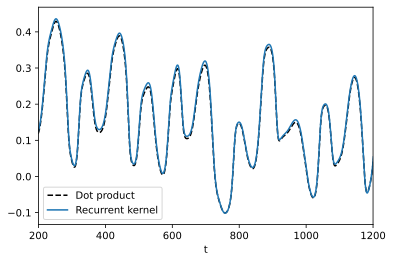

In [16]:
i = 250
plt.plot(K_baseline[i, :], 'k--', label='Dot product')
plt.plot(K_recurrent[i, :], label='Recurrent kernel')
plt.xlabel('t')
plt.legend()

plt.xlim([200, 1200])

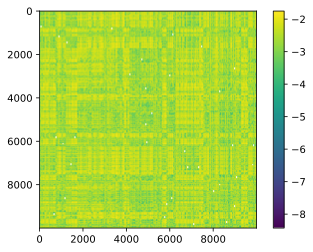

In [17]:
plt.imshow(jnp.log10(jnp.abs(K_baseline - K_recurrent)))
plt.colorbar()

In [18]:
jnp.mean(jnp.abs(K_baseline - K_recurrent))

DeviceArray(0.00388785, dtype=float32)

(2000.0, 4000.0)

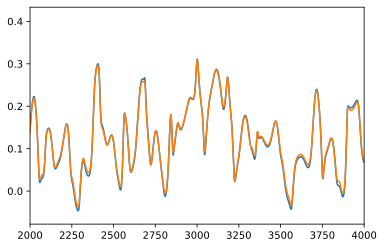

In [19]:
frame = 100
plt.plot(K_baseline[:, frame])
plt.plot(K_recurrent[:, frame])

plt.xlim([2000, 4000])

There shouldnt be a memory, so the error should be constant

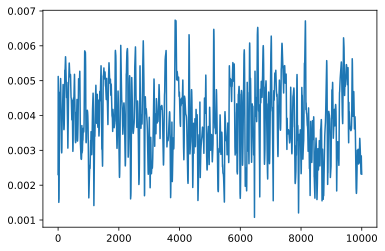

In [20]:
plt.plot(jnp.mean(jnp.abs(K_baseline - K_recurrent), axis=1))

At least its fairly random, thats good.

In [21]:
jnp.save("K_diagonal.npy", K_recurrent)

How much l2 do we need to make a non-nan output?

In [22]:
renorm = 1.1
sigma_i = 0.4
sigma_r = 0.9
sigma_b = 0.4

K_train = recurrent_kernel(erf_kernel, sigma_i, sigma_r, sigma_b, data)
K_train += renorm * jnp.dot(data, data.T)  # Adding gram matrix 

ini = 1000 # we remove the first 1000 warmup time
K_train = K_train[ini:, ini:]

# L2
alpha = 1e-2
K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data[ini:], check_finite=False)

In [23]:
W_out

DeviceArray([[ 0.00417204,  0.00711858,  0.00804765, ..., -0.00528385,
              -0.00311043,  0.00035015],
             [ 0.00314626,  0.00629272,  0.0076675 , ..., -0.00553963,
              -0.00376862, -0.00060027],
             [ 0.00211389,  0.0053532 ,  0.00709041, ..., -0.00563195,
              -0.00426559, -0.00145641],
             ...,
             [-0.0066653 , -0.00619415, -0.00348009, ..., -0.00052787,
              -0.00293555, -0.00530921],
             [-0.00691376, -0.00640934, -0.00353939, ..., -0.00034187,
              -0.00293735, -0.0054727 ],
             [-0.00721283, -0.00659827, -0.00351677, ..., -0.00019943,
              -0.00301542, -0.0057159 ]], dtype=float32)

So more or less 1e-2; that seems acceptable.... To double check if we're correct, we can run the off-diagonal function on the diagonal; it should yield the same results.

In [24]:
kernel_fn = erf_kernel
gram = jnp.dot(data, data.T)
n_samples = gram.shape[0]

# Getting diagonal results
k_diagonal = jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel_fn), 0.0, jnp.diag(gram))[1]
k_diagonal = jnp.concatenate([jnp.zeros(1, ), k_diagonal[:-1]]) # first element should be zero

In [25]:
k_diagonal

DeviceArray([0.        , 0.28934404, 0.37456805, ..., 0.41068947,
             0.4108657 , 0.41120026], dtype=float32)

In [26]:
k_off_diagonal = jax.lax.scan(off_diagonal_update_fn(sigma_i, sigma_r, sigma_b, erf_kernel, gram, k_diagonal, 0), 0.0, jnp.arange(n_samples))[1]

In [27]:
k_off_diagonal

DeviceArray([0.28934404, 0.37456805, 0.3937268 , ..., 0.4108657 ,
             0.41120026, 0.41171366], dtype=float32)

In [28]:
jnp.allclose(k_off_diagonal[:-1], k_diagonal[1:])

DeviceArray(True, dtype=bool)

Okay so off diagonal and diagonal are the same, as it should be.